In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
!pip install ngboost

from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=4a6fd73d84941c97249cf6339c9c12a5ecbfdd9b6ff6c79354cd1a804cd92002
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
Mounted at /content/drive


In [ ]:
# Load the data
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Carbon_Torsion_UC.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu
0,1,320,28100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02
1,1,320,32100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02
2,1,310,90400,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02
3,1,310,119000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02
4,1,300,263000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,36,320,88300,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11
374,36,310,117000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11
375,36,300,144000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11
376,36,300,321000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11


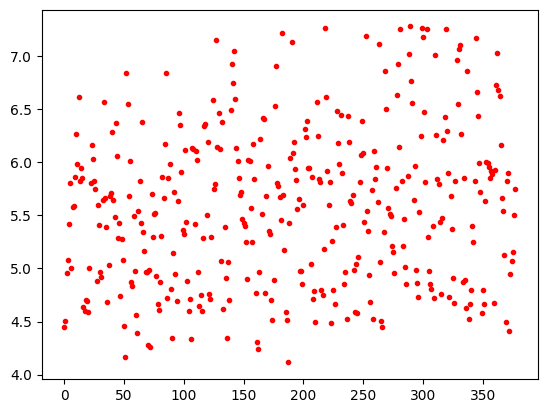

In [ ]:
# Scatter Plot for the Target Column
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# # Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Heat','Number of Cycles'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu
0,360,550,825,0.10,0.03,0.01,33,22,63,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02
1,320,550,610,0.07,0.00,0.03,33,21,62,0.26,0.23,0.51,0.018,0.024,0.01,0.02,0.01
2,350,550,1270,0.12,0.01,0.00,33,22,66,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02
3,290,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08
4,280,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,360,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11
374,310,600,1270,0.08,0.01,0.00,33,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01
375,290,600,825,0.10,0.03,0.01,33,25,66,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02
376,350,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
        return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
[iter 0] loss=1.0856 val_loss=1.1378 scale=1.0000 norm=0.4671
[iter 100] loss=0.9662 val_loss=1.0728 scale=2.0000 norm=0.8229
[iter 200] loss=0.8702 val_loss=1.0315 scale=1.0000 norm=0.3899
[iter 300] loss=0.7774 val_loss=1.0048 scale=1.0000 norm=0.3789
== Early stopping achieved.
== Best iteration / VAL309 (val_loss=1.0035)
Pearson CC: 0.4777817086117589
R2 score: 0.17929295868766537
RMSE: 0.6964771078464227
MAE: 0.5775949234797498
Coverage: 97.36842105263158
Upper coverage: 98.68421052631578
Lower coverage: 98.68421052631578
Average Interval Width: 2.588891346299244
Median Interval Width: 2.631904508267627
Composite Metric: 0.8252514066000651


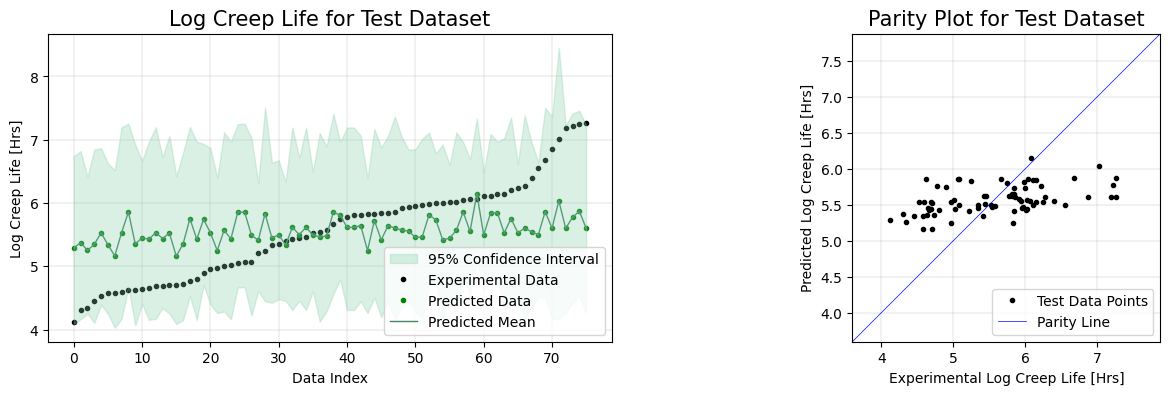

Run # 1 Fold # 2
[iter 0] loss=1.0800 val_loss=1.1181 scale=1.0000 norm=0.4756
[iter 100] loss=0.9498 val_loss=1.0444 scale=1.0000 norm=0.4019
[iter 200] loss=0.8493 val_loss=1.0028 scale=1.0000 norm=0.3825
[iter 300] loss=0.7621 val_loss=0.9708 scale=1.0000 norm=0.3748
== Early stopping achieved.
== Best iteration / VAL337 (val_loss=0.9597)
Pearson CC: 0.6034766599225339
R2 score: 0.28797968353546377
RMSE: 0.6678310965131271
MAE: 0.5519083331151666
Coverage: 96.05263157894736
Upper coverage: 99.99999999999999
Lower coverage: 96.05263157894736
Average Interval Width: 2.3219589631977446
Median Interval Width: 2.220303693852537
Composite Metric: 0.8329919462653869


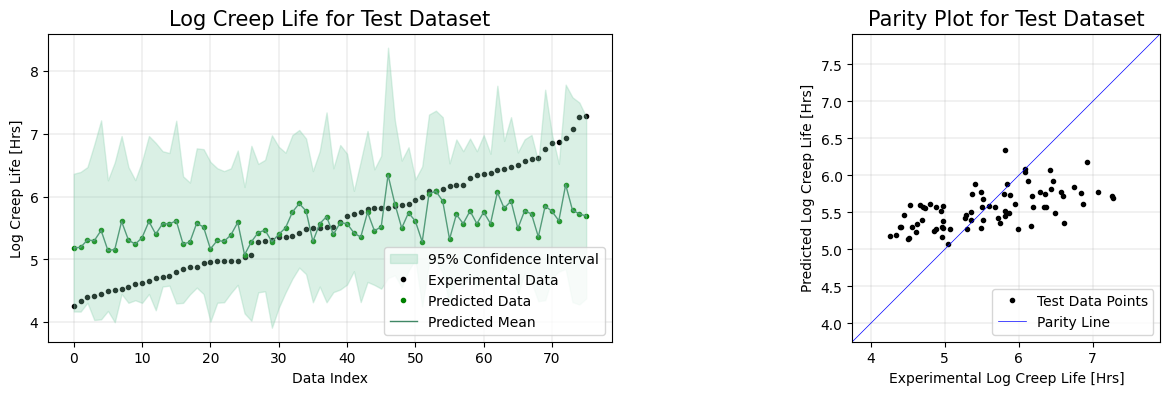

Run # 1 Fold # 3
[iter 0] loss=1.1145 val_loss=1.1564 scale=1.0000 norm=0.4669
[iter 100] loss=0.9875 val_loss=1.0947 scale=1.0000 norm=0.3893
[iter 200] loss=0.8889 val_loss=1.0460 scale=2.0000 norm=0.7259
== Early stopping achieved.
== Best iteration / VAL255 (val_loss=1.0299)
Pearson CC: 0.6709446257565307
R2 score: 0.2909711159739663
RMSE: 0.5846225927200035
MAE: 0.46537623394060096
Coverage: 96.05263157894737
Upper coverage: 99.99999999999999
Lower coverage: 96.05263157894737
Average Interval Width: 2.4909851884892085
Median Interval Width: 2.5130832733786796
Composite Metric: 0.819874130401512


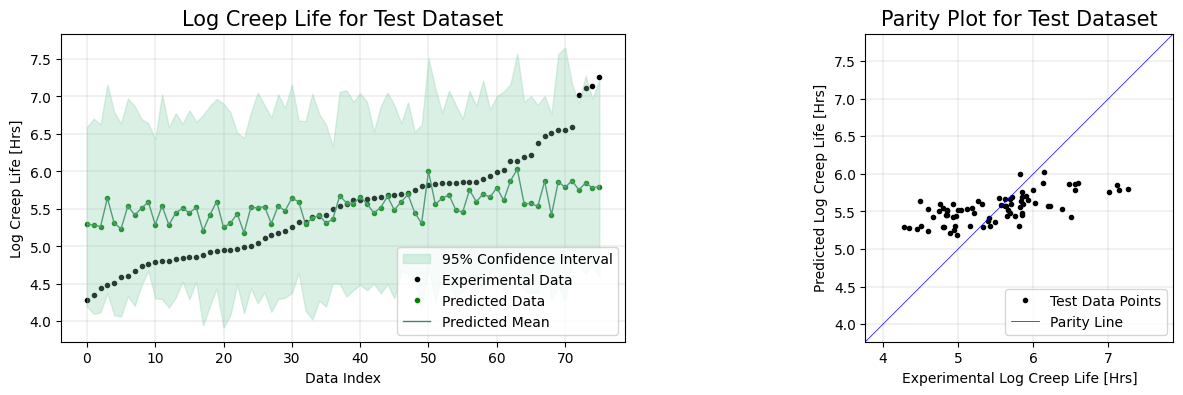

Run # 1 Fold # 4
[iter 0] loss=1.1048 val_loss=1.1420 scale=1.0000 norm=0.4611
[iter 100] loss=0.9693 val_loss=1.0875 scale=1.0000 norm=0.3930
[iter 200] loss=0.8764 val_loss=1.0596 scale=1.0000 norm=0.3769
== Early stopping achieved.
== Best iteration / VAL262 (val_loss=1.0495)
Pearson CC: 0.40980165867911467
R2 score: 0.1575499957643649
RMSE: 0.6693931067143988
MAE: 0.5200035095914949
Coverage: 94.66666666666666
Upper coverage: 98.66666666666664
Lower coverage: 96.0
Average Interval Width: 2.521409218168059
Median Interval Width: 2.5318108611078767
Composite Metric: 0.808743553019835


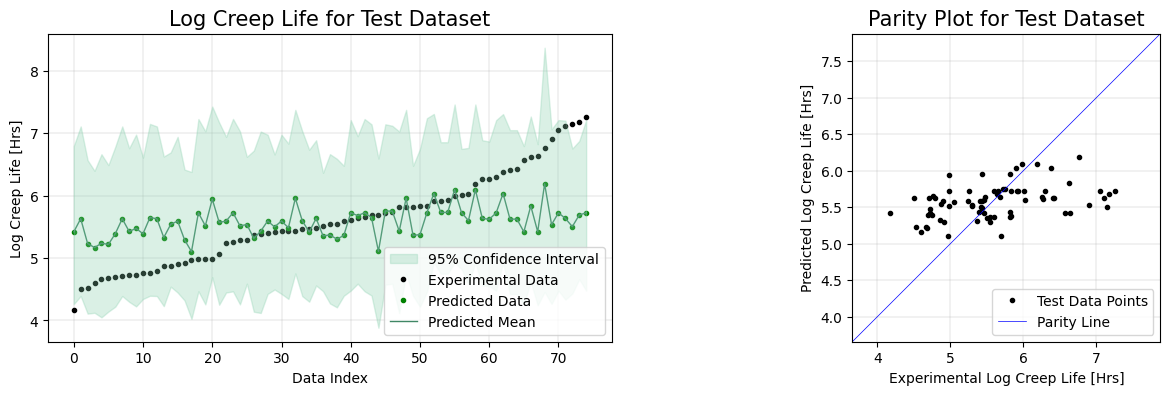

Run # 1 Fold # 5
[iter 0] loss=1.1041 val_loss=1.1499 scale=1.0000 norm=0.4681
[iter 100] loss=0.9679 val_loss=1.0985 scale=1.0000 norm=0.3951
[iter 200] loss=0.8655 val_loss=1.0590 scale=1.0000 norm=0.3781
[iter 300] loss=0.7749 val_loss=1.0210 scale=1.0000 norm=0.3722
[iter 400] loss=0.6948 val_loss=0.9870 scale=1.0000 norm=0.3679
== Early stopping achieved.
== Best iteration / VAL474 (val_loss=0.9742)
Pearson CC: 0.5701617011893576
R2 score: 0.27644926611086484
RMSE: 0.5977202489824163
MAE: 0.49605292891455177
Coverage: 95.99999999999999
Upper coverage: 97.33333333333331
Lower coverage: 98.66666666666666
Average Interval Width: 2.0691809877599185
Median Interval Width: 2.0478846251610623
Composite Metric: 0.8420771897637239


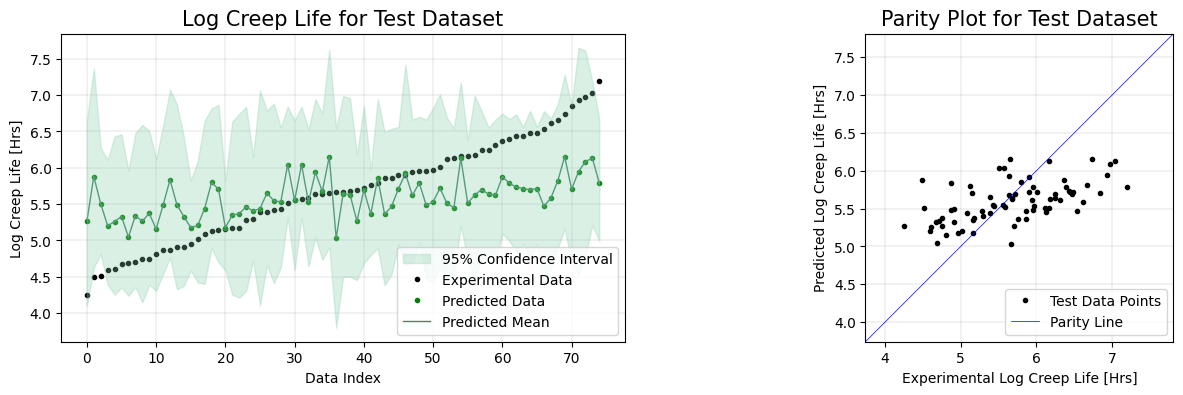

In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=66+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]
            X_train, X_val, y_train, Y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42)

            model = NGBRegressor(Dist=LogNormal, n_estimators=1000, learning_rate=0.005)

            model.fit(X_train, y_train, X_val=X_val, Y_val=Y_val, early_stopping_rounds=4)

            y_pred_test = model.predict(X_test)

            y_test_ngb = model.pred_dist(X_test)

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            df_test_low = y_test_ngb.interval(0.95)[0]
            df_test_median = y_pred_test
            df_test_high = y_test_ngb.interval(0.95)[1]

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            upper_coverage[j, i] = coverage(y_test, df_test_low, np.inf)
            lower_coverage[j, i] = coverage(y_test, -np.inf, df_test_high)

            print(f'Coverage: {test_coverage[j, i]}')
            print(f'Upper coverage: {upper_coverage[j, i]}')
            print(f'Lower coverage: {lower_coverage[j, i]}')

            # Prediction interval width
            mean_interval_width[j, i] = np.mean(df_test_high - df_test_low)
            print(f'Average Interval Width: {mean_interval_width[j, i]}')
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test
            y_std = np.std(np.array(y_pred_test), axis=0)

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, df_test_low, df_test_high, alpha=0.3, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            ## Parity Plot
            # find the boundaries of y_test and y_pred values
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            ax[1].plot(y_test, y_pred, 'ko', markersize=3, label="Test Data Points")
            ax[1].legend(loc=4, fontsize=10, frameon=False)
            ax[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            ax[1].legend(loc=4, fontsize=10, frameon=True)
            ax[1].set_xlabel("Experimental Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_ylabel("Predicted Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_title("Parity Plot for Test Dataset", fontsize=15)
            ax[1].grid(True, which='major', linestyle='-', linewidth='0.25')
            ax[1].set_xlim(bounds)
            ax[1].set_ylim(bounds)
            ax[1].set_aspect("equal", adjustable="box") # Square aspect ratio

            plt.show()

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.477782,0.179293,0.696477,0.577595,97.368421
1,0.603477,0.287980,0.667831,0.551908,96.052632
2,0.670945,0.290971,0.584623,0.465376,96.052632
3,0.409802,0.157550,0.669393,0.520004,94.666667
4,0.570162,0.276449,0.597720,0.496053,96.000000


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.546433,0.092414,0.238449,0.057793,0.643209,0.043888,0.522187,0.03967,96.02807,0.854629


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,97.368421,98.684211,98.684211,2.588891,2.631905,0.825251
1,96.052632,100.000000,96.052632,2.321959,2.220304,0.832992
2,96.052632,100.000000,96.052632,2.490985,2.513083,0.819874
3,94.666667,98.666667,96.000000,2.521409,2.531811,0.808744
4,96.000000,97.333333,98.666667,2.069181,2.047885,0.842077


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,96.02807,0.854629,98.936842,0.996862,97.091228,1.293657,2.398485,0.186665,2.388997,0.218912,0.825788,0.01134
